In [1]:
## Import basic modules and routines
from __future__ import division, absolute_import, print_function

From sky to Time-Ordered Data (and back): Dichroic detectors
====

This notebook describes how to generate timestreams from a scan of the sky using dichroic detectors.

**Note**

The implementation of dichroic lives in a separate branch than the master one for the moment (still experimental).
In order to play with dichroic, you need to checkout the origin/dichroic branch.

**Summary of the change**

Long story short, if you want to use dichroic you need to do the following steps in addition to the standard case:
* Modify your instrument to have dichroic: `inst.make_dichroic(fwhm=X)`.
* Create two sets of maps by passing the arg `fwhm_in2` in `HealpixFitsMap`.
* Use `mode='dichroic'` when initialising your TOD.
* Project back in map domain each channel separately using `frequency_channel=Y` in `tod.tod2map`.

** Pipeline view **

Roughly speaking, you have two classes of things: 1. those who need to be doubled and 2. those who can be shared. Example (non comprehensive):
1. Detector properties (polarisation angle, beam, gain, ...), noise properties, input skies (same seed but different resolution), wirings.
2. Scanning strategy, pointing matrix.

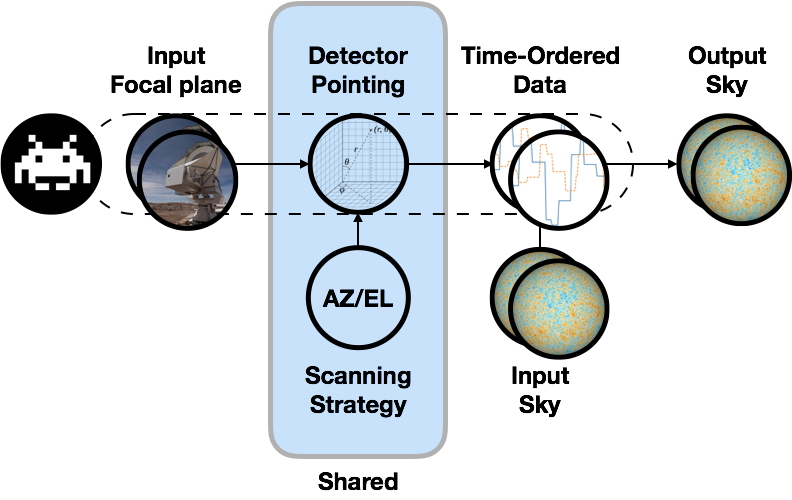

In [2]:
from IPython.display import Image
Image(filename='../data/dichroic.png')

Et voilà, as simple as that! Here is a full example:

In [3]:
## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

import numpy as np
import pylab as pl
import healpy as hp

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

First, let's create a simple instrument following the instrument notebook and add dichroic detectors with different resolution (3.5 arcmin and 15 arcmin):

In [4]:
from s4cmb.instrument import Hardware

inst = Hardware(
    ncrate=4, ndfmux_per_crate=1,         
    nsquid_per_mux=1, npair_per_squid=16,         
    fp_size=60., fwhm=3.5,          
    beam_seed=58347, projected_fp_size=3., pm_name='5params',      
    type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)
inst.make_dichroic(fwhm=15.)

Then, we need to define a scanning strategy. Again, following the scanning strategy notebook we use the ScanningStrategy class. For this example, we generate only one scan (one CES) of 4 hours:

In [5]:
from s4cmb.scanning_strategy import ScanningStrategy

scan = ScanningStrategy(
    nces=1, start_date='2013/1/1 00:00:00',
    telescope_longitude='-67:46.816',
    telescope_latitude='-22:56.396', telescope_elevation=5200.,
    name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
    ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem',
    language='fortran', verbose=False)
scan.run()

Note that unlike the scanning strategy notebook, we use language=fortran to benefit from a massive speed-up. Finally, one needs to simulate a CMB sky to be scanned. The necessary tools are found in the module input_sky.py. for test purposes, we create the (Gaussian) maps on-the-fly from a CAMB file, but in real-life run you may want to read your own file (properly lensed for example). Note that HealpixFitsMap can take as inputs either CAMB file, or fits file containing either maps or alms. In addition, we create a second set of maps with the second resolution:

In [6]:
from s4cmb.input_sky import HealpixFitsMap

nside_out = 512
path_to_cls = '../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat'
sky_in = HealpixFitsMap(
    path_to_cls, do_pol=True, fwhm_in=inst.beam_model.fwhm,
    fwhm_in2=inst.beam_model2.fwhm,
    nside_in=nside_out, map_seed=5843787, 
    verbose=False, no_ileak=False, no_quleak=False)

Let's now generate our TOD from our input sky, instrument, and scanning strategy. Since we have only one scan in this example, we have:

In [7]:
from s4cmb.tod import TimeOrderedDataPairDiff

tod = TimeOrderedDataPairDiff(
    inst, scan, sky_in, 
    CESnumber=0, 
    projection='healpix', 
    pixel_size=None, nside_out=nside_out, 
    array_noise_level=None, array_noise_seed=None,
    width=130., mapping_perpair=False, mode='dichroic')
        
## Scan input map to get TODs
d = np.array([
        tod.map2tod(det) for det in tqdm(
            range(inst.focal_plane.nbolometer))])

100%|██████████| 128/128 [00:10<00:00, 12.74it/s]


OK, let's have a look at those TOD! Here, a TOD means d(t) = I(t) + Q(t)cos(2theta(t)) + U(t)sin(2theta(t)) for the two frequency channels. You can simply split the two TOD:

In [8]:
## First frequency of observation
d1 = d[:, 0]

## Second frequency of observation
d2 = d[:, 1]

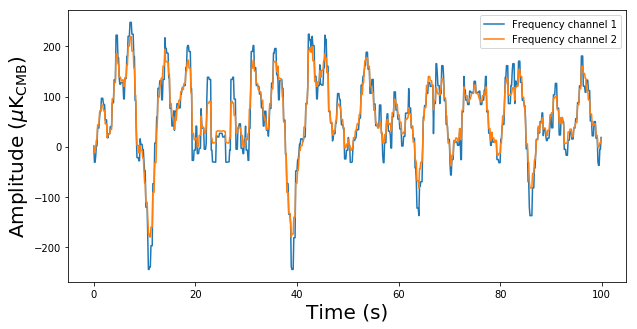

In [9]:
stop = 800
xaxis = [t/scan.sampling_freq for t in range(0, stop)]

fig = pl.figure(figsize=(10, 5))

pl.plot(xaxis, d1[0][0:stop], label='Frequency channel 1')
pl.plot(xaxis, d2[0][0:stop], label='Frequency channel 2')

pl.xlabel('Time (s)', fontsize=20)
pl.ylabel('Amplitude ($\mu$K$_{\\rm CMB}$)', fontsize=20)
pl.legend()
pl.show()

Let's now project back our data into a sky map. We will use the difference of pairs of detectors to reconstruct the polarisation. We will do that for both channels of observation:

In [10]:
from s4cmb.tod import OutputSkyMap

## Initialise output map container
sky1 = OutputSkyMap(
    projection=tod.projection,
    nside=tod.nside_out,
    obspix=tod.obspix,
    npixsky=tod.npixsky,
    pixel_size=tod.pixel_size)
sky2 = OutputSkyMap(
    projection=tod.projection,
    nside=tod.nside_out,
    obspix=tod.obspix,
    npixsky=tod.npixsky,
    pixel_size=tod.pixel_size)

tod.tod2map(d1, sky1, frequency_channel=1)
tod.tod2map(d2, sky2, frequency_channel=2)

In the absence of systematics, these operations should not change the signal (that is map1 -> tod -> map2 implies map2 = map1). Let's check that we did not harm the signal:

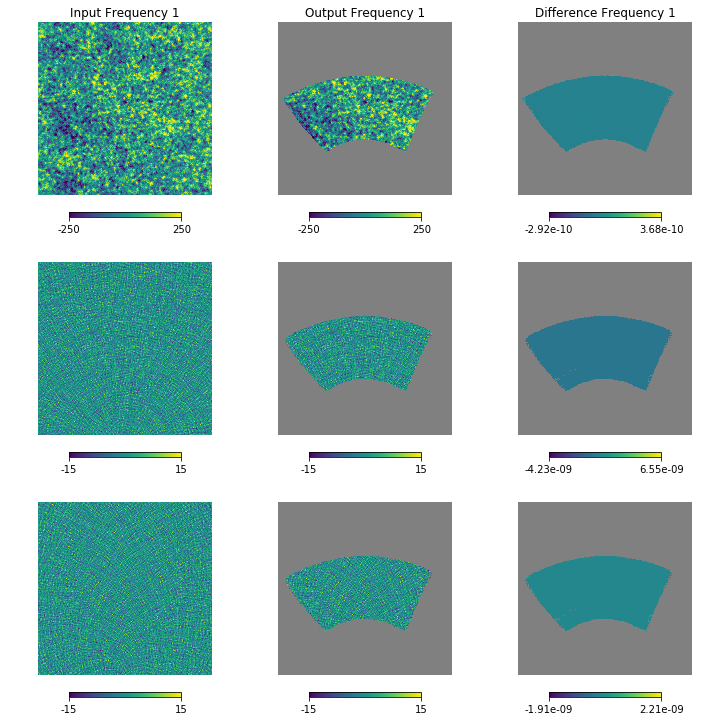

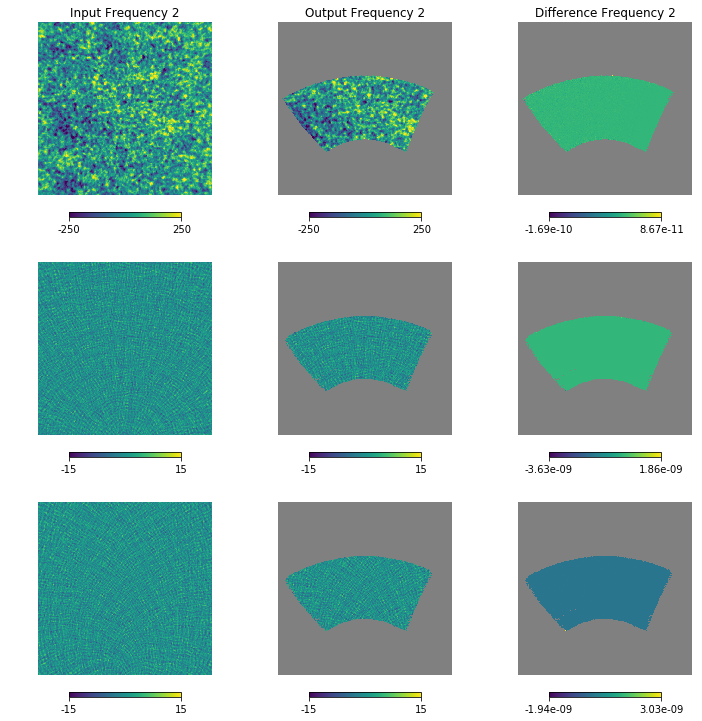

In [12]:
from s4cmb.tod import partial2full

xsize = 550

for sky, pos, name in zip([sky1, sky2], ['', '2'], ['Frequency 1', 'Frequency 2']):
    fig = pl.figure(figsize=(10, 10))

    nhit = partial2full(sky.nhit, sky.obspix, 
                           sky.nside, fill_with=0.0)

    ## Temperature
    sky_out = partial2full(sky.get_I(), sky.obspix, 
                           sky.nside, fill_with=0.0)

    mask = nhit < 1
    sky_out[mask] = np.nan
    hp.gnomview(getattr(sky_in, 'I{}'.format(pos)), 
                rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
                title='Input {}'.format(name), 
                notext=True, min=-250, max=250)
    hp.gnomview(sky_out, 
                rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
                title='Output {}'.format(name), 
                notext=True, min=-250, max=250)
    hp.gnomview(getattr(sky_in, 'I{}'.format(pos)) - sky_out, 
                rot=[0, -57.5], xsize=xsize, reso=6.9, sub=333, 
                title='Difference {}'.format(name), 
                notext=True)

    ## Stokes Q
    sky_out = partial2full(sky.get_QU()[0], sky.obspix, 
                           sky.nside, fill_with=0.0)
    mask = nhit < 10
    sky_out[mask] = np.nan

    hp.gnomview(getattr(sky_in, 'Q{}'.format(pos)), 
                rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
                notext=True, min=-15, max=15, title='')
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
                notext=True, min=-15, max=15, title='')
    hp.gnomview(getattr(sky_in, 'Q{}'.format(pos)) - sky_out, 
                rot=[0, -57.5], xsize=xsize, reso=6.9, sub=336, 
                notext=True, title='')

    ## Stokes U
    sky_out = partial2full(sky.get_QU()[1], sky.obspix, 
                           sky.nside, fill_with=0.0)
    mask = nhit < 10
    sky_out[mask] = np.nan
    hp.gnomview(getattr(sky_in, 'U{}'.format(pos)), 
                rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
                notext=True, min=-15, max=15, title='')
    hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338, 
                notext=True, min=-15, max=15, title='')
    hp.gnomview(getattr(sky_in, 'U{}'.format(pos)) - sky_out, 
                rot=[0, -57.5], xsize=xsize, reso=6.9, sub=339, 
                notext=True, title='')
    pl.show()

The difference is indeed negligible in the two channels!